In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from pathlib import Path
import scanpy as sc
import geopandas as gpd
from sklearn_ann.kneighbors.annoy import AnnoyTransformer
# to install %pip install -q "scanpy" "sklearn-ann[annoy]"
import matplotlib.pyplot as plt


In [2]:
segmentation_path = Path(
    "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
    "dietary_droject/data/cell_segmentation"
)
full_data_path = segmentation_path / "concatenated"
adata_file     = full_data_path / "combined_adata.h5ad"

# where to dump CSVs of top markers
hvg_dir = full_data_path / "analysis" / "HVG"
hvg_dir.mkdir(parents=True, exist_ok=True)

# path to your cell-cycle gene lists
geneList = (
    "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
    "dietary_droject/data/cell_typing_reference_from_pc/Gene_lists"
)

# Load data
ST_sample = sc.read_h5ad(adata_file)

In [3]:
# 1. Print number of cells BEFORE subsetting
print(f"Before subsetting: {ST_sample.n_obs} cells")

# 2. Define the samples you want to keep
samples_to_keep = ['F07833', 'F07834', 'F07835', 'F07836']

# 3. Perform subsetting
ST_sample = ST_sample[ST_sample.obs['sample_id'].isin(samples_to_keep)].copy()

# 4. Print number of cells AFTER subsetting
print(f"After subsetting: {ST_sample.n_obs} cells")

# 5. Quick sanity check: Which sample_ids are present now?
print("Remaining sample_ids:", ST_sample.obs['sample_id'].unique())


Before subsetting: 1193549 cells
After subsetting: 846263 cells
Remaining sample_ids: ['F07833', 'F07834', 'F07835', 'F07836']
Categories (4, object): ['F07833', 'F07834', 'F07835', 'F07836']


In [4]:
# Cleaning
# Identify mitochondrial genes (prefix 'MT-' for human)
ST_sample.var['mito'] = ST_sample.var_names.str.startswith('mt-')

#  Run QC metrics
sc.pp.calculate_qc_metrics(
    ST_sample, 
    qc_vars=['mito'], 
    inplace=True, 
    log1p=False
)

sc.pp.filter_cells(ST_sample, min_counts=30)
sc.pp.filter_genes(ST_sample, min_cells=5)
ST_sample = ST_sample[
    (ST_sample.obs['total_counts'] >= 50) &
    (ST_sample.obs['pct_counts_mito'] <= 15)
].copy()

In [5]:
# normalize + log1p
sc.pp.normalize_total(ST_sample, target_sum=1e4)
sc.pp.log1p(ST_sample)

In [6]:
#Cell-cycle scoring
with open(f"{geneList}/cc_mouse_cycle_genes.json") as jf:
    cc = json.load(jf)
s_genes_mouse   = cc["s_genes"]
g2m_genes_mouse = cc["g2m_genes"]


sc.tl.score_genes_cell_cycle(
    ST_sample,
    s_genes   = s_genes_mouse,
    g2m_genes = g2m_genes_mouse,
    use_raw   = False
)

In [7]:
# HVG selection
sc.pp.highly_variable_genes(
    ST_sample,
    n_top_genes=2000,
    flavor="seurat_v3",
    batch_key="TMA"
)
ST_sample = ST_sample[:, ST_sample.var['highly_variable']].copy()

/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [8]:
sc.pp.regress_out(
    ST_sample,
    keys=['total_counts', 'pct_counts_mito', 'S_score', 'G2M_score']
)

In [9]:
 # Scale so each gene has unit variance
sc.pp.scale(ST_sample, max_value=10)

In [10]:
# PCA with randomized SVD
n_pcs = 80
sc.tl.pca(ST_sample, n_comps=n_pcs, svd_solver="randomized")

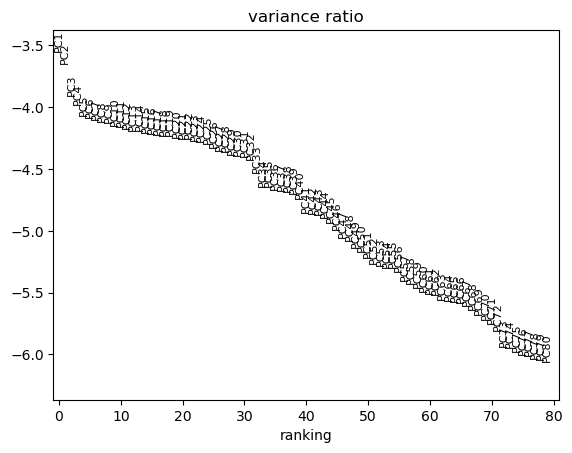

In [11]:
sc.pl.pca_variance_ratio(ST_sample, n_pcs=n_pcs, log=True)

In [12]:
# sc.pp.neighbors(
#     ST_sample,
#     n_neighbors=15,        # Lower = more asymmetry
#     method='umap',         # Default graph construction method
#     knn=True               # Ensures k-nearest neighbor graph (as opposed to full distance matrix)
# )
# Memory efficient
sc.pp.neighbors(
    ST_sample,
    n_neighbors=20,
    n_pcs=33,  
    transformer=AnnoyTransformer(n_trees=100),
    method="umap",
    knn=True
)

In [13]:
sc.tl.leiden(
    ST_sample,
    resolution=0.6,
    flavor="igraph",
    directed=False,    # Undirected - forces a two way link
    n_iterations=2,
    random_state=1337
)

In [ ]:
sc.tl.umap(ST_sample,
          maxiter = 200)

/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 265 with accuracies 
[1.04302029e-15 3.31037186e-05 4.46182465e-05 2.18161173e-05]
not reaching the requested tolerance 2.2858381271362305e-05.
Use iteration 155 instead with accuracy 
1.3189301052414533e-05.

  _, diffusion_map = lobpcg(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.05489510e-15 1.08698568e-05 1.74417522e-05 2.44455952e-05]
not reaching the requested tolerance 2.2858381271362305e-05.
  _, diffusion_map = lobpcg(


In [ ]:
sc.pl.umap(
    ST_sample,
    color='leiden',    # color by your leiden clusters
    palette='tab20',   # nice large color palette
    size=5,            # small dots for large datasets (~1M cells)
    frameon=False,
    title='Leiden Clustering (Resolution 0.6)'
)

In [ ]:
# rsc.tl.umap(
#     ST_sample,
#     min_dist=0.5,
#     spread=1.0,
#     n_components=2,
#     maxiter=250,     # default 500
#     init_pos='random', # or 'spectral'
#     random_state=1337
#     # key_added="X_umap_gpu" # If I want to differentiate between embeddings
# )

In [ ]:
# Saving UMAP results

# ST_sample.obsm['X_umap_leiden_res0_6'] = ST_sample.obsm['X_umap'].copy()

# # optionally delete the original if you want:
# del ST_sample.obsm['X_umap']

# ST_sample.write(full_data_path / "analysis" / "combined_processed_with_umap.h5ad")

# Per Cluster Analysis

In [ ]:
sc.tl.rank_genes_groups(
    ST_sample,
    groupby='leiden',         # your clustering
    method='wilcoxon',        # robust non-parametric test
    pts=True,                 # calculate % of cells expressing
    key_added='rank_genes'    # store under a custom key
)


In [ ]:
# Define output directory
marker_out_dir = full_data_path / "analysis" / "HVG"
marker_out_dir.mkdir(parents=True, exist_ok=True)

# Get all Leiden cluster labels
clusters = ST_sample.obs['leiden'].unique().tolist()

# For each cluster
for cluster in clusters:
    # Extract marker genes for that cluster
    deg_df = sc.get.rank_genes_groups_df(
        ST_sample,
        group=cluster,
        key='rank_genes'
    )
    
    # Pick top 50 genes (you can change this)
    top_deg = deg_df.head(50)

    # Save to CSV
    out_path = marker_out_dir / f"cluster_{cluster}_top50_markers.csv"
    top_deg.to_csv(out_path, index=False)
    
    print(f"Saved markers for cluster {cluster} → {out_path}")